In [1]:
from IPython.display import Image

# CNTK 101: Logistic Regression and ML Primer

This tutorial is targeted to individuals who are new to CNTK and to machine learning. In this tutorial, you will train a simple yet powerful machine learning model that is widely used in industry for a variety of applications. The model trained below scales to massive data sets in the most expeditious manner by harnessing computational scalability leveraging the computational resources you may have (one or more CPU cores, one or more GPUs, a cluster of CPUs or a cluster of GPUs), transparently via the CNTK library.

The following notebook users Python APIs. If you are looking for this example in BrainScript, please look [here](https://github.com/Microsoft/CNTK/tree/v2.0.rc1/Tutorials/HelloWorld-LogisticRegression). 

## Introduction

**Problem**:
A cancer hospital has provided data and wants us to determine if a patient has a fatal [malignant][] cancer vs. a benign growth. This is known as a classification problem. To help classify each patient, we are given their age and the size of the tumor. Intuitively, one can imagine that younger patients and/or patient with small tumor size are less likely to have malignant cancer. The data set simulates this application where the each observation is a patient represented as a dot (in the plot below) where red color indicates malignant and blue indicates benign disease. Note: This is a toy example for learning, in real life there are large number of features from different tests/examination sources and doctors'  experience that play into the diagnosis/treatment decision for a patient.
[malignant]: https://en.wikipedia.org/wiki/Malignancy

In [2]:
# Figure 1
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400)

**Goal**:
Our goal is to learn a classifier that automatically can label any patient into either benign or malignant category given two features (age and tumor size). In this tutorial, we will create a linear classifier that is a fundamental building-block in deep networks.

In [3]:
# Figure 2
Image(url= "https://www.cntk.ai/jup/cancer_classify_plot.jpg", width=400, height=400)

In the figure above, the green line represents the learnt model from the data and separates the blue dots from the red dots. In this tutorial, we will walk you through the steps to learn the green line. Note: this classifier does make mistakes where couple of blue dots are on the wrong side of the green line. However, there are ways to fix this and we will look into some of the techniques in later tutorials. 

**Approach**: 
Any learning algorithm has typically five stages. These are Data reading, Data preprocessing, Creating a model, Learning the model parameters, and Evaluating (a.k.a. testing/prediction) the model. 

>1. Data reading: We generate simulated data sets with each sample having two features (plotted below) indicative of the age and tumor size.
>2. Data preprocessing: Often the individual features such as size or age needs to be scaled. Typically one would scale the data between 0 and 1. To keep things simple, we are not doing any scaling in this tutorial (for details look here: [feature scaling][]).
>3. Model creation: We introduce a basic linear model in this tutorial. 
>4. Learning the model: This is also known as training. While fitting a linear model can be done in a variety of ways ([linear regression][]), in CNTK we use Stochastic Gradient Descent a.k.a. [SGD][].
>5. Evaluation: This is also known as testing where one takes data sets with known labels (a.k.a. ground-truth) that was not ever used for training. This allows us to assess how a model would perform in real world (previously unseen) observations.

## Logistic Regression
[Logistic regression][] is fundamental machine learning technique that uses a linear weighted combination of features and generates the probability of predicting different classes. In our case the classifier will generate a  probability in [0,1] which can then be compared with a threshold (such as 0.5) to produce a binary label (0 or 1). However, the method shown can be extended to multiple classes easily. 
[feature scaling]: https://en.wikipedia.org/wiki/Feature_scaling
[SGD]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[linear regression]: https://en.wikipedia.org/wiki/Linear_regression
[logistic regression]: https://en.wikipedia.org/wiki/Logistic_regression
[softmax]: https://en.wikipedia.org/wiki/Multinomial_logistic_regression

In [4]:
# Figure 3
Image(url= "https://www.cntk.ai/jup/logistic_neuron.jpg", width=300, height=200)

In the figure above, contributions from different input features are linearly weighted and aggregated. The resulting sum is mapped to a 0-1 range via a [sigmoid][] function. For classifiers with more than two output labels, one can use a [softmax][] function.
[sigmoid]: https://en.wikipedia.org/wiki/Sigmoid_function

In [5]:
# Import the relevant components
from __future__ import print_function
import numpy as np
import sys
import os
from cntk import *

# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    import cntk
    if os.environ['TEST_DEVICE'] == 'cpu':
        cntk.device.try_set_default_device(cntk.device.cpu())
    else:
        cntk.device.try_set_default_device(cntk.device.gpu(0))


## Data Generation
Let us generate some synthetic data emulating the cancer example using `numpy` library. We have two features (represented in two-dimensions)  each either being to one of the two classes (benign:blue dot or malignant:red dot). 

In our example, each observation in the training data has a label (blue or red) corresponding to each observation (set of features - age and size). In this example, we have two classes represented by labels 0 or 1, thus a  binary classification task. 

In [6]:
# Define the network
input_dim = 2
num_output_classes = 2

### Input and Labels

In this tutorial we are generating synthetic data using `numpy` library. In real world problems, one would use a [reader][], that would read feature values (`features`: *age* and *tumor size*) corresponding to each obeservation (patient). The simulated *age* variable is scaled down to have similar range as the other variable. This is a key aspect of data pre-processing that we will learn more in later tutorials. Note, each observation can reside in a higher dimension space (when more features are available) and will be represented as a [tensor][] in CNTK. More advanced tutorials shall introduce the handling of high dimensional data.

[reader]: https://github.com/Microsoft/CNTK/search?p=1&q=reader&type=Wikis&utf8=%E2%9C%93
[tensor]: https://en.wikipedia.org/wiki/Tensor

In [7]:
# Ensure we always get the same amount of randomness
np.random.seed(0)

# Helper function to generate a random data sample
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # Create synthetic data using NumPy. 
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Make sure that the data is separable 
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    
    # Specify the data type to match the input variable used later in the tutorial 
    # (default type is double)
    X = X.astype(np.float32)    
    
    # converting class 0 into the vector "1 0 0", 
    # class 1 into vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y   

In [8]:
# Create the input variables denoting the features and the label data. Note: the input 
# does not need additional info on number of observations (Samples) since CNTK creates only 
# the network topology first 
mysamplesize = 32
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes)

Let us visualize the input data.

**Note**: If the import of `matplotlib.pyplot` fails, please run `conda install matplotlib` which will fix the `pyplot` version dependencies. If you are on a python environment different from Anaconda, then use `pip install`.

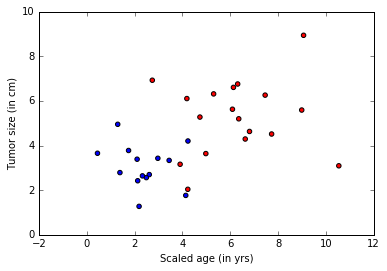

In [9]:
# Plot the data 
import matplotlib.pyplot as plt
%matplotlib inline

# given this is a 2 class () 
colors = ['r' if l == 0 else 'b' for l in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()

# Model Creation

A logistic regression (a.k.a. LR) network is the simplest building block but has been powering many ML 
applications in the past decade. LR is a simple linear model that takes as input, a vector of numbers describing the properties of what we are classifying (also known as a feature vector, $\bf{x}$, the blue nodes in the figure) and emits the *evidence* ($z$) (output of the green node, a.k.a. as activation). Each feature in the input layer is connected with a output node by a corresponding weight w (indicated by the black lines of varying thickness). 

In [10]:
# Figure 4
Image(url= "https://www.cntk.ai/jup/logistic_neuron2.jpg", width=300, height=200)

The first step is to compute the evidence for an observation. 

$$z = \sum_{i=1}^n w_i \times x_i + b = \textbf{w} \cdot \textbf{x} + b$$ 

where $\bf{w}$ is the weight vector of length $n$ and $b$ is known as the [bias][] term. Note: we use **bold** notation to denote vectors. 

The computed evidence is mapped to a 0-1 scale using a [`sigmoid`][] (when the outcome can take one of two values) or a `softmax` function (when the outcome can take one of more than 2 classes value).

Network input and output: 
- **input** variable (a key CNTK concept): 
>An **input** variable is a user-code facing container where user-provided code fills in different observations (data point or sample, equivalent to a blue/red dot in our example) as inputs to the model function during model learning (a.k.a.training) and model evaluation (a.k.a. testing). Thus, the shape of the `input` must match the shape of the data that will be provided.  For example, when data are images each of  height 10 pixels  and width 5 pixels, the input feature dimension will be 2 (representing image height and width). Similarly, in our example the dimensions are age and tumor size, thus `input_dim` = 2. More on data and their dimensions to appear in separate tutorials. 

[bias]: https://www.quora.com/What-does-the-bias-term-represent-in-logistic-regression

[`sigmoid`]: https://en.wikipedia.org/wiki/Sigmoid_function

In [11]:
feature = input(input_dim, np.float32)

## Network setup

The `linear_layer` function is a straight forward implementation of the equation above. We perform two operations:
0. multiply the weights ($\bf{w}$)  with the features ($\bf{x}$) using CNTK `times` operator and add individual features' contribution,
1. add the bias term $b$.

These CNTK operations are optimized for execution on the available hardware and the implementation hides the complexity away from the user. 

In [12]:
# Define a dictionary to store the model parameters
mydict = {"w":None,"b":None} 

def linear_layer(input_var, output_dim):
    
    input_dim = input_var.shape[0]
    weight_param = parameter(shape=(input_dim, output_dim))
    bias_param = parameter(shape=(output_dim))
    
    mydict['w'], mydict['b'] = weight_param, bias_param

    return times(input_var, weight_param) + bias_param

`z` will be used to represent the output of a network.

In [13]:
output_dim = num_output_classes
z = linear_layer(feature, output_dim)

### Learning model parameters

Now that the network is setup, we would like to learn the parameters $\bf w$ and $b$ for our simple linear layer. To do so we convert, the computed evidence ($z$) into a set of predicted probabilities ($\textbf p$) using a `softmax` function.

$$ \textbf{p} = \mathrm{softmax}(z)$$ 

The `softmax` is an activation function that maps the accumulated evidences to a probability distribution over the classes (Details of the [softmax function][]). Other choices of activation function can be [found here][].

[softmax function]: https://www.cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax

[found here]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

## Training
The output of the `softmax` is a probability of observations belonging to the respective classes. For training the classifier, we need to determine what behavior the model needs to mimic. In other words, we want the generated probabilities to be as close as possible to the observed labels. This function is called the *cost* or *loss* function and shows what is the difference between the learnt model vs. that generated by the training set.

[`Cross-entropy`][] is a popular function to measure the loss. It is defined as:

$$ H(p) = - \sum_{j=1}^C y_j \log (p_j) $$  

where $p$ is our predicted probability from `softmax` function and $y$ represents the label. This label provided with the data for training is also called the ground-truth label. In the two-class example, the `label` variable has dimensions of two (equal to the `num_output_classes` or $C$). Generally speaking, if the task in hand requires classification into $C$ different classes, the label variable will have $C$ elements with 0 everywhere except for the class represented by the data point where it will be 1.  Understanding the [details][] of this cross-entropy function is highly recommended.

[`cross-entropy`]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.cross_entropy_with_softmax
[details]: http://colah.github.io/posts/2015-09-Visual-Information/

In [14]:
label = input((num_output_classes), np.float32)
loss = cross_entropy_with_softmax(z, label)

#### Evaluation

In order to evaluate the classification, one can compare the output of the network which for each observation emits a vector of evidences (can be converted into probabilities using `softmax` functions) with dimension equal to number of classes.

In [15]:
eval_error = classification_error(z, label)

### Configure training

The trainer strives to reduce the `loss` function by different optimization approaches, [Stochastic Gradient Descent][] (`sgd`) being one of the most popular one. Typically, one would start with random initialization of the model parameters. The `sgd` optimizer would calculate the `loss` or error between the predicted label against the corresponding ground-truth label and using [gradient-decent][] generate a new set model parameters in a single iteration. 

The aforementioned model parameter update using a single observation at a time is attractive since it does not require the entire data set (all observation) to be loaded in memory and also requires gradient computation over fewer datapoints, thus allowing for training on large data sets. However, the updates generated using a single observation sample at a time can vary wildly between iterations. An intermediate ground is to load a small set of observations and use an average of the `loss` or error from that set to update the model parameters. This subset is called a *minibatch*.

With minibatches we often sample observation from the larger training dataset. We repeat the process of model parameters update using different combination of training samples and over a period of time minimize the `loss` (and the error). When the incremental error rates are no longer changing significantly or after a preset number of maximum minibatches to train, we claim that our model is trained.

One of the key parameter for optimization is called the `learning_rate`. For now, we can think of it as a scaling factor that modulates how much we change the parameters in any iteration. We will be covering more details in later tutorial. 
With this information, we are ready to create our trainer. 

[optimization]: https://en.wikipedia.org/wiki/Category:Convex_optimization
[Stochastic Gradient Descent]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[gradient-decent]: http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html

In [16]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.5
lr_schedule = learning_rate_schedule(learning_rate, UnitType.minibatch) 
learner = sgd(z.parameters, lr_schedule)
trainer = Trainer(z, (loss, eval_error), [learner])

First let us create some helper functions that will be needed to visualize different functions associated with training. Note these convinience functions are for understanding what goes under the hood.

In [17]:

# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=10):
    if len(a) < w: 
        return a[:]    
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"

    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

### Run the trainer

We are now ready to train our Logistic Regression model. We want to decide what data we need to feed into the training engine.

In this example, each iteration of the optimizer will work on 25 samples (25 dots w.r.t. the plot above) a.k.a. `minibatch_size`. We would like to train on say 20000 observations. If the number of samples in the data is only 10000, the trainer will make 2 passes through the data. This is represented by `num_minibatches_to_train`. Note: In real world case, we would be given a certain amount of labeled data (in the context of this example, observation (age, size) and what they mean (benign / malignant)). We would use a large number of observations for training say 70% and set aside the remainder for evaluation of the trained model.

With these parameters we can proceed with training our simple feedforward network.

In [18]:
# Initialize the parameters for the trainer
minibatch_size = 25
num_samples_to_train = 20000
num_minibatches_to_train = int(num_samples_to_train  / minibatch_size)

In [19]:
# Run the trainer and perform model training
training_progress_output_freq = 50

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, num_minibatches_to_train):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    # Specify input variables mapping in the model to actual minibatch data to be trained with
    trainer.train_minibatch({feature : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)
        

Minibatch: 0, Loss: 0.6931, Error: 0.32
Minibatch: 50, Loss: 1.4795, Error: 0.36
Minibatch: 100, Loss: 1.1093, Error: 0.32
Minibatch: 150, Loss: 0.3336, Error: 0.20
Minibatch: 200, Loss: 0.1325, Error: 0.08
Minibatch: 250, Loss: 0.1334, Error: 0.08
Minibatch: 300, Loss: 0.1012, Error: 0.04
Minibatch: 350, Loss: 0.1103, Error: 0.04
Minibatch: 400, Loss: 0.3099, Error: 0.08
Minibatch: 450, Loss: 0.3240, Error: 0.12
Minibatch: 500, Loss: 0.3922, Error: 0.20
Minibatch: 550, Loss: 0.6709, Error: 0.24
Minibatch: 600, Loss: 0.3018, Error: 0.12
Minibatch: 650, Loss: 0.1677, Error: 0.12
Minibatch: 700, Loss: 0.2782, Error: 0.12
Minibatch: 750, Loss: 0.2313, Error: 0.04


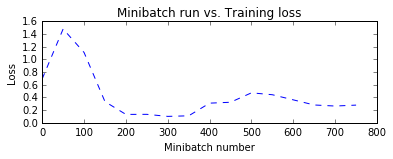

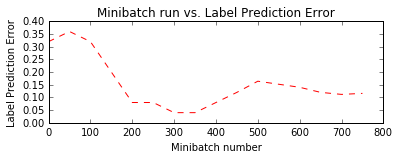

In [20]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

## Evaluation / Testing 

Now that we have trained the network. Let us evaluate the trained network on data that hasn't been used for training. This is called **testing**. Let us create some new data and evaluate the average error and loss on this set. This is done using `trainer.test_minibatch`. Note the error on this previously unseen data is comparable to training error. This is a **key** check. Should the error be larger than the training error by a large margin, it indicates that the trained model will not perform well on data that it has not seen during training. This is known as [overfitting][]. There are several ways to address overfitting that is beyond the scope of this tutorial but the Cognitive Toolkit provides the necessary components to address overfitting.

Note: We are testing on a single minibatch for illustrative purposes. In practice one runs several minibatches of test data and reports the average. 

**Question** Why is this suggested? Try plotting the test error over several set of generated data sample and plot using plotting functions used for training. Do you see a pattern?

[overfitting]: https://en.wikipedia.org/wiki/Overfitting


In [21]:
# Run the trained model on newly generated dataset
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({feature : features, label : labels}) 

0.12

### Checking prediction / evaluation 
For evaluation, we map the output of the network between 0-1 and convert them into probabilities for the two classes. This suggests the chances of each observation being malignant and benign. We use a softmax function to get the probabilities of each of the class. 

In [22]:
out = softmax(z)
result = out.eval({feature : features})

Let us compare the ground-truth label with the predictions. They should be in agreement.

**Question:** 
- How many predictions were mislabeled? Can you change the code below to identify which observations were misclassified? 

In [23]:
print("Label    :", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(result[i,:]) for i in range(len(result))])

Label    : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Predicted: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]


### Visualization
It is desirable to visualize the results. In this example, the data is conveniently in two dimensions and can be plotted. For data with higher dimensions, visualization can be challenging. There are advanced dimensionality reduction techniques that allow for such visualizations [t-sne][].

[t-sne]: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

[ 8.00762081 -8.00761986]


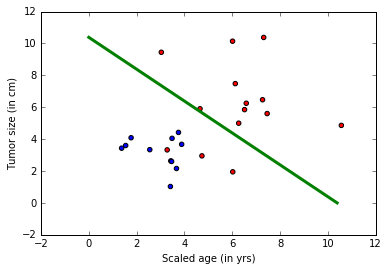

In [24]:
# Model parameters
print(mydict['b'].value)

bias_vector   = mydict['b'].value
weight_matrix = mydict['w'].value

# Plot the data 
import matplotlib.pyplot as plt

# given this is a 2 class 
colors = ['r' if l == 0 else 'b' for l in labels[:,0]]
plt.scatter(features[:,0], features[:,1], c=colors)
plt.plot([0, bias_vector[0]/weight_matrix[0][1]], 
         [ bias_vector[1]/weight_matrix[0][0], 0], c = 'g', lw = 3)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()

**Exploration Suggestions** 
- Try exploring how the classifier behaves with different data distributions - suggest changing the `minibatch_size` parameter from 25 to say 64. Why is the error increasing?
- Try exploring different activation functions
- Try exploring different learners 
- You can explore training a [multiclass logistic regression][] classifier.

[multiclass logistic regression]: https://en.wikipedia.org/wiki/Multinomial_logistic_regression